In [13]:
import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns

def get_data():
    stock = pd.read_csv('Data/ExistenciasNew.csv')
    sales = pd.read_csv('Data/FacturacionCorregida.csv',parse_dates=['Fecha'],dayfirst=True ,sep=';')
    products = pd.read_csv('Data/MaestroCorregido.csv', sep=';')
    return stock, sales, products


def clean_products(products):
    products.columns = [column.upper() for column in products.columns]
    products.columns = [column.lstrip('001-') for column in products.columns]
    products.columns = [column.replace('.', '') for column in products.columns]
    products.columns = [column.replace(' ', '_') for column in products.columns]
    products.columns = [column.replace('_EXHIBIDO', '') for column in products.columns]
    products.columns = [column.replace('_UNIFICADA', '') for column in products.columns]
    products = products.rename(columns={
        'DESC_ITEM':'DESC_LARGA',
        'DESC_EXT_1_DETALLE':'DETALLE_1',
        'DESC_EXT_2_DETALLE':'DETALLE_2',
        'DESC_TIPO_INVENTARIO':'TIPO_INVENTARIO',
        'DEPARTAMENTO':'CATEGORIA',
        'MATERIAL_PPAL':'MATERIAL',
        'PUESTOS':'PUESTOS_STR',
        'NUM_PUESTOS':'PUESTOS',
        'REF_COMBINADA':'REF',
        'COLOR_DEF':'COLOR',
    })

    regex = '^([A-Z0-9]+\s\-\s)+'
    products.SUBCATEGORIA = products.SUBCATEGORIA.str.replace(regex,'',regex=True)
    products.ORIGEN = products.ORIGEN.str.replace(regex,'',regex=True)
    products.CATEGORIA = products.CATEGORIA.str.replace(regex,'',regex=True)
    products.ESTILO = products.ESTILO.str.replace(regex,'',regex=True)
    products.VIGENCIA = products.VIGENCIA.str.replace(regex,'',regex=True)
    products.MATERIAL = products.MATERIAL.str.replace(regex,'',regex=True).str.upper()
    products.ACABADO = products.ACABADO.str.upper().replace('SUPERFICIES MATE','MATE')
    products.DETALLE_1.fillna('N/A',inplace=True)
    products.DETALLE_2.fillna('N/A',inplace=True)
    products['PUESTOS'] = products.PUESTOS_STR.str.slice(stop=1).replace({'N':0,'M':7}).astype(int).replace({0:np.nan})
    products = products[['ITEM','REF','DESCRIPCION','CATEGORIA','SUBCATEGORIA','VIGENCIA','ORIGEN',
                         'ESTILO','MATERIAL','ACABADO','PUESTOS','COLOR','ANCHO','ALTO','FONDO','DESC_LARGA']]
    return products

def clean_sales(sales):
    sales.columns = [column.upper() for column in sales.columns]
    sales.columns = [column.replace('.', '') for column in sales.columns]
    sales.columns = [column.replace(' ', '_') for column in sales.columns]
    sales = sales.groupby(['CO','DESC_CO','NRO_DOCUMENTO','REF_COMBINADA','FECHA'])[['CANTIDAD_INV','SUMA_DE_VLR_BRUTO','SUMA_DE_VLR_SUBTOTAL']].sum().reset_index()
    sales['ID'] = sales['CO'].astype(str)+':'+sales['NRO_DOCUMENTO']+':'+sales['REF_COMBINADA']
    sales["DESCUENTO(%)"] = (sales['SUMA_DE_VLR_BRUTO']-sales['SUMA_DE_VLR_SUBTOTAL'])/sales['SUMA_DE_VLR_BRUTO']
    sales['PRECIO'] = sales['SUMA_DE_VLR_BRUTO']/sales['CANTIDAD_INV']
    sales['MES'] = sales['FECHA'].dt.month
    sales['ANIO'] = sales['FECHA'].dt.year
    sales['DIA'] = sales['FECHA'].dt.weekday
    sales = sales.rename(columns={
        'CO':'CODIGO_TIENDA',
        'DESC_CO':'TIENDA',
        'REF_COMBINADA':'PROD_REF',
        'CANTIDAD_INV':'CANTIDAD',
        'SUMA_DE_VLR_BRUTO':'SUBTOTAL',
        'SUMA_DE_VLR_SUBTOTAL':'TOTAL',
    })
    sales = sales[['ID','NRO_DOCUMENTO','FECHA','CODIGO_TIENDA','TIENDA','PROD_REF','CANTIDAD','PRECIO',
                   'SUBTOTAL','DESCUENTO(%)','TOTAL','ANIO','MES','DIA']]
    return sales

def clean_stock(stock):
    stock.columns = [column.upper() for column in stock.columns]
    stock.columns = [column.replace('.', '') for column in stock.columns]
    stock.columns = [column.replace(' ', '_') for column in stock.columns]
    
    stock = stock.rename(columns={
        'EXT_1_DETALLE':'DETALLE_1',
        'EXT_2_DETALLE':'DETALLE_2',
        'REF_COMBINADA':'REF',
        'REFERENCIA':'ID',
        'DISP':'CANTIDAD',
        'DEPARTAMENTO':'CATEGORIA'
    })
    
    regex = '^([A-Z0-9]+\s\-\s)+'
    stock.CATEGORIA = stock.CATEGORIA.str.replace(regex,'',regex=True)
    stock.SUBCATEGORIA = stock.SUBCATEGORIA.str.replace(regex,'',regex=True)
    
    stock = stock[['ID','REF','CANTIDAD','CATEGORIA','SUBCATEGORIA','DETALLE_1','DETALLE_2']]
    return stock

def create_merges(sales,products):
    sales_prod = sales.merge(products, left_on='PROD_REF', right_on='REF')
    stock_prod = stock.drop(columns=['CATEGORIA','SUBCATEGORIA']).merge(products, on='REF', how='left')
    return sales_prod, stock_prod

def create_subcategories_list(sales_prod):
    subcategories_list = []
    temp = sales_prod.groupby('SUBCATEGORIA')["CANTIDAD"].sum().sort_values(ascending=False)
    totalSales = temp.sum()
    pareto = totalSales*0.8
    counter = 0
    
    temp = temp.to_frame().reset_index()
    for index, row in temp.iterrows():
        counter += row["CANTIDAD"]
        subcategories_list.append(row["SUBCATEGORIA"])
        if counter >= pareto:
            break
    return subcategories_list

def create_materials_list(sales_prod):
    materials_list = sales_prod.groupby(['MATERIAL'])['CANTIDAD'].sum().sort_values(ascending=False)
    cumpperce = materials_list.cumsum()/materials_list.sum()*100
    materials_list = cumpperce[cumpperce<91].to_frame().rename(columns={'CANTIDAD':'CANTIDAD(%)'})
    return materials_list

def create_consolidated(sales_prod):
    consolidated = sales_prod.groupby('REF').aggregate(
        CANTIDAD=pd.NamedAgg(column="CANTIDAD", aggfunc="sum"),
        TOTAL=pd.NamedAgg(column="TOTAL", aggfunc="sum"), 
        PRECIO_PROMEDIO=pd.NamedAgg(column='PRECIO',aggfunc='mean'),
        DESCUENTO_PROMEDIO=pd.NamedAgg(column='DESCUENTO(%)', aggfunc= 'mean')
    ).reset_index().merge(products, on='REF').sort_values(by='CANTIDAD', ascending=False)
    return consolidated

def add_category_pos(row):
    if row["SUBCATEGORIA"] in subcategories_list:
        index = row["SUBCATEGORIA"]
    else:
        index = "OTROS"
    return index

def add_pos_cols(arr):
    arr["SUBCATEGORIA_POS"] = arr.apply(add_category_pos,axis = 1 )
    arr['COLOR_POS'] = np.where(
        arr["COLOR"].isin(['NEGRO','GRIS','CAFE', 'BLANCO','AZUL','MIEL','BEIGE','CRISTAL','ROJO','AMARILLO']),
        arr["COLOR"],
        'OTRO'
    )
    arr['MATERIAL_POS']=np.where(arr['MATERIAL'].isin(materials_list.index), arr['MATERIAL'], 'OTRO')
    return



stock, sales, products = get_data()

products = clean_products(products)
sales = clean_sales(sales)
stock = clean_stock(stock)

sales_prod, stock_prod = create_merges(sales,products)
groupby_sales = create_consolidated(sales_prod)

subcategories_list = create_subcategories_list(sales_prod)
materials_list = create_materials_list(sales_prod)

add_pos_cols(sales_prod)
add_pos_cols(products)
add_pos_cols(stock_prod)
add_pos_cols(groupby_sales)

# Redes Neuronales

## Preprocesamiento de datos

In [28]:
#sales_prod['dayofyear'] =  sales_prod['FECHA'].dt.dayofyear
#sales_prod['dayofweek'] =  sales_prod['FECHA'].dt.dayofweek

sales_prod['AREA']=sales_prod['ANCHO']*sales_prod['FONDO']

basedate = pd.Timestamp('2019-01-02')
sales_ref_month=sales_prod.groupby(['ANIO','MES','REF']).agg({'PRECIO':'mean','SUBTOTAL':'sum','DESCUENTO(%)':'mean','TOTAL':'sum','CANTIDAD':'sum','ALTO':'first','AREA':'first','PUESTOS':'first','COLOR_POS':'first','CATEGORIA':'first','SUBCATEGORIA_POS':'first','VIGENCIA':'first','ORIGEN':'first','ESTILO':'first','MATERIAL_POS':'first','ACABADO':'first'}).reset_index().sort_values(by=['ANIO','MES'])

In [35]:
sales_ref_month.dtypes

ANIO                  int64
MES                   int64
REF                  object
PRECIO              float64
SUBTOTAL              int64
DESCUENTO(%)        float64
TOTAL                 int64
CANTIDAD              int64
ALTO                float64
AREA                float64
PUESTOS             float64
COLOR_POS            object
CATEGORIA            object
SUBCATEGORIA_POS     object
VIGENCIA             object
ORIGEN               object
ESTILO               object
MATERIAL_POS         object
ACABADO              object
dtype: object

In [42]:
from sklearn.preprocessing import StandardScaler


nn_data = sales_ref_month[['MES','ALTO','AREA','DESCUENTO(%)','ORIGEN','CATEGORIA','SUBCATEGORIA_POS','ESTILO','MATERIAL_POS','ACABADO','COLOR_POS']]
nn_data = pd.get_dummies(nn_data, drop_first  = True,columns = ['MES','ORIGEN','CATEGORIA','SUBCATEGORIA_POS','ESTILO','MATERIAL_POS','ACABADO','COLOR_POS'])
nn_data = nn_data.dropna()

X = nn_data
y = np.asanyarray(sales_ref_month.CANTIDAD)


X_norm = StandardScaler().fit_transform(nn_data)
y_norm = StandardScaler().fit_transform(y.reshape(-1,1))

In [56]:
X_train = X.loc[(sales_ref_month.ANIO != 2021) | (sales_ref_month.MES != 4),:]

X_test = X.loc[(sales_ref_month.ANIO == 2021) | (sales_ref_month.MES == 4),:]

y_train = y[(sales_ref_month.ANIO != 2021) | (sales_ref_month.MES != 4)]
y_test = y[(sales_ref_month.ANIO == 2021) | (sales_ref_month.MES == 4)]

X_train_norm = X_norm[(sales_ref_month.ANIO != 2021) | (sales_ref_month.MES != 4)]
X_test_norm = X_norm[(sales_ref_month.ANIO == 2021) | (sales_ref_month.MES == 4)]

y_train_norm = y_norm[(sales_ref_month.ANIO != 2021) | (sales_ref_month.MES != 4)]

y_test_norm = y_norm[(sales_ref_month.ANIO == 2021) | (sales_ref_month.MES == 4)]

## ARQUITECTURA RED NEURONAL

In [57]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD

In [94]:
# define model
model = Sequential()
model.add(Dense(164, input_dim=58, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(164, activation='relu'))
model.add(Dense(68, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='mean_squared_error', optimizer=opt)

In [95]:
# fit model
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='loss', patience=2)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size = 10,callbacks = callback)

Epoch 1/10
953/953 [==============================] - 2s 2ms/step - loss: 84.8973 - val_loss: 36.6219
Epoch 2/10
953/953 [==============================] - 2s 2ms/step - loss: 84.8894 - val_loss: 36.6219
Epoch 3/10
953/953 [==============================] - 2s 2ms/step - loss: 84.8894 - val_loss: 36.6218
Epoch 4/10
953/953 [==============================] - 2s 3ms/step - loss: 84.8894 - val_loss: 36.6218


Train: 84.889, Test: 36.622


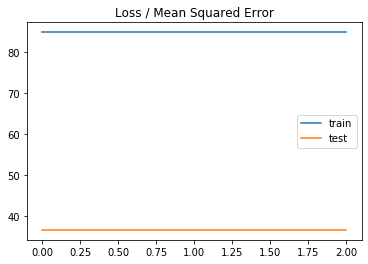

In [91]:
# evaluate the model
train_mse = model.evaluate(X_train, y_train, verbose=0)
test_mse = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

# plot loss during training
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [93]:
y_predict = model.predict(X_test)
for i in range(30):
	print("Real=%s, Predicted=%s" % (y_test[i], y_predict[i]))

Real=1, Predicted=[1.]
Real=2, Predicted=[1.]
Real=3, Predicted=[1.]
Real=1, Predicted=[1.]
Real=1, Predicted=[1.]
Real=2, Predicted=[1.]
Real=4, Predicted=[1.]
Real=1, Predicted=[1.]
Real=2, Predicted=[1.]
Real=1, Predicted=[1.]
Real=1, Predicted=[1.]
Real=2, Predicted=[1.]
Real=1, Predicted=[1.]
Real=2, Predicted=[1.]
Real=2, Predicted=[1.]
Real=3, Predicted=[1.]
Real=2, Predicted=[1.]
Real=2, Predicted=[1.]
Real=1, Predicted=[1.]
Real=2, Predicted=[1.]
Real=2, Predicted=[1.]
Real=1, Predicted=[1.]
Real=1, Predicted=[1.]
Real=3, Predicted=[1.]
Real=2, Predicted=[1.]
Real=1, Predicted=[1.]
Real=1, Predicted=[1.]
Real=2, Predicted=[1.]
Real=4, Predicted=[1.]
Real=1, Predicted=[1.]
